In [1]:
import cv2
import csv
import numpy as np
import sklearn
from keras.models import Sequential, Model, load_model
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D, Dropout
from keras.layers.pooling import MaxPooling2D
from keras.layers.advanced_activations import ELU
import matplotlib.pyplot as plt
from keras.optimizers import Adam
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
def browseAllImages(dataDir):
    """
    Finds all the images in data set directory
    """
    lines = []
    with open(dataDir + '/driving_log.csv') as csvFile:
        reader = csv.reader(csvFile)
        for line in reader:
            lines.append(line)
    SumCenter = []
    SumLeft = []
    SumRight = [] 
    SumMeasurement = []
    centerImg = []
    leftImg = []
    rightImg = []
    measurements = []
    for line in lines:
        angles=float(line[3])
        measurements.append(angles)
        centerImg.append(dataDir + '/' + line[0].strip())
        leftImg.append(dataDir + '/' + line[1].strip())
        rightImg.append(dataDir + '/' + line[2].strip())
    SumCenter.extend(centerImg)
    SumLeft.extend(leftImg)
    SumRight.extend(rightImg)
    SumMeasurement.extend(measurements)

    return (SumCenter, SumLeft, SumRight, SumMeasurement)

In [3]:
def mixingImages(centerImg, leftImg, rightImg, steering, adjustment):
    """
    Combine all images from center, left and right camera. Apply angle adjustment on each left
    and right camera
    
    """
    #Initialized place holder for image lists
    imageList = []
        
    #Initialized place holder for angle measurement
    angles = []
    
    #Create array of center camera Images
    imageList.extend(centerImg)
    angles.extend(steering)
    
    #Create array of Left camera steering. Adjust steering with adjustment (+) plus value
    imageList.extend(leftImg)
    angles.extend([addangle + adjustment for addangle in steering])
    
    #Create array of right camera steering. Adjust steering with adjustment (-) minus value 
    angles.extend([subsangle - adjustment for subsangle in steering])
    imageList.extend(rightImg)
    
    return (imageList, angles)

In [4]:
def rand_bright(imageToProcess):
    """
    Retun a random brightness images
    """
    # Convert colorspace to HSY
    image = cv2.cvtColor(imageToProcess, cv2.COLOR_RGB2HSV)
    
    # Generate random number of brightness factor
    brightness = .25 + np.random.uniform()
    image[:,:,2] = image[:,:,2] * brightness
    
    # Convert colorspace back to RGB
    brightImage = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    return brightImage


In [5]:
def generator(sampleData, batch_size=32):
    """
    Generate sample data for fit generator. Data augmented with random brightness and flip.
    """
    #set max data set base of number of batch size
    maxData=len(sampleData)-(len(sampleData)%batch_size)
    
    checkBatchSize=0
    
    while True: 
        
        #suffle images before batching
        sampleData = sklearn.utils.shuffle(sampleData)
        
        for x in range(0, maxData, batch_size):
                      
            process_batch = sampleData[x:x+batch_size]
                
            images = []
            angles = []
            
            for cameraImgDir, steeringAngle in process_batch:

                # read image as BGR. Covert to RGB
                image = cv2.cvtColor(cv2.imread(cameraImgDir), cv2.COLOR_BGR2RGB)
                
                # apply random bright
                image=rand_bright(image)

                # append image and angle on arrays
                images.append(image)
                angles.append(steeringAngle)
                
                # apply image flipping and steering angle adjustment
                images.append(cv2.flip(image,1))
                angles.append(steeringAngle*-1.0)
 
            yield sklearn.utils.shuffle(np.array(images), np.array(angles))

In [6]:
def initializedModel():
    """
    Creates a model with the normalized and cropping.
    """
    # Use Sequential
    model = Sequential()
    # Normalized
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
    
    # Crop to remove skies and tress
    model.add(Cropping2D(cropping=((50,20), (0,0))))
    return model

In [7]:
def nVidiaModel():
    """
    Adopted from nVidia model with relu activation
    """
    model = initializedModel()
    model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Convolution2D(64,3,3, activation='relu'))
    model.add(Flatten())
    model.add(Dense(100))
    model.add(Dropout(.5)) #add Dropout to nVidia model
    model.add(Dense(50))
    model.add(Dropout(.2)) #add Dropout to nVidia model
    model.add(Dense(10))
    model.add(Dense(1))
    return model

In [8]:
# Reading images locations.
#data='external/data' #combined data location
data='data/' #provided data location
centerImages, leftImages, rightImages, measurements = browseAllImages(data)
imageList, SteerAngle = mixingImages(centerImages, leftImages, rightImages, measurements, 0.2)
print('Total Images: {}'.format( len(imageList)))
print('Total measurements: {}'.format( len(SteerAngle)))

Total Images: 24108
Total measurements: 24108


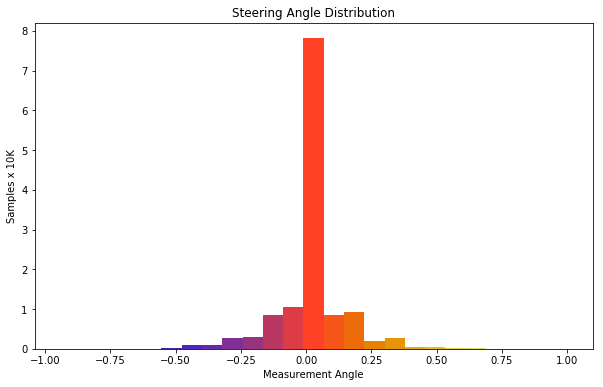

In [9]:
#print a histogram to see which steering angle distribution

#Set histogram size
plt.figure(figsize=(10,6))

#Devine color map theme
colorMap = plt.cm.get_cmap('CMRmap')

# Plot angle measuement histogram.
n, bins, patches = plt.hist(measurements, 25, normed=1, color='blue')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.title('Steering Angle Distribution')
plt.ylabel('Samples x 10K')
plt.xlabel('Measurement Angle')

# scale values to [0,1]
columns = bin_centers - min(bin_centers)
columns /= max(columns)

for color, patch in zip(columns, patches):
    plt.setp(patch, 'facecolor', colorMap(color))
plt.show()
#plt.savefig('output/histogram.png')

In [10]:
# Splitting samples and creating generators.
from sklearn.model_selection import train_test_split
dataSet = list(zip(imageList, SteerAngle))

#Split 20% for validation samples
trainDataSet, validDataSet = train_test_split(dataSet, test_size=0.2)

In [11]:
print('Train Data Set: {}'.format(len(trainDataSet)))
print('Validation Data Set: {}'.format(len(validDataSet)))

Train Data Set: 19286
Validation Data Set: 4822


In [12]:
#Generate train and validation batch
batch=64

max_train=len(trainDataSet)-(len(trainDataSet)%batch)
max_val=len(validDataSet)-(len(validDataSet)%batch)

train_gen = generator(trainDataSet, batch_size=batch)
valid_gen = generator(validDataSet, batch_size=batch)

In [13]:
# Model creation
#model = nVidiaModel1()   #Elu on dense + conv layer
#model = nVidiaModel2() #Relu only
#model = nVidiaModel3() #Relu & Elu
model = nVidiaModel() #Relu on con layer

In [ ]:
#Set model parameter
n_of_epoch=2
learning_rate = 0.001
optimizer = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

In [ ]:
# Compiling and training the model

model.compile(optimizer=optimizer, loss="mse", )

history_object = model.fit_generator(train_gen, samples_per_epoch= \
                 max_train, validation_data=valid_gen, \
                 nb_val_samples=max_val, nb_epoch=n_of_epoch,verbose=1)


Epoch 1/2
17792/19264 [==========================>...] - ETA: 66s - loss: 0.0280

In [ ]:
model.save('model_train.h5')

In [ ]:
print('Model summary',model.summary())

In [ ]:
#Plot loss graphic
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('Adam, MSE loss, Rate=0.001')
plt.ylabel('Mean Square Error Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')
#plt.savefig('output/trainingloss.png')
plt.show()